In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2
from PIL import Image,ImageDraw,ImageFont
import os
import re
from io import BytesIO

In [2]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [42]:
input_img = "imgs/1.jpg"
input_background = "imgs/tarae.jpg"
keyword = "니 머리털 꿀타래"

In [222]:
if len(keyword) > 12:
  space_iter = re.finditer('\s', keyword)
  space_list = []
  for i in space_iter:
    space_list.append(i)
  split_index = space_list[int(len(space_list)/2)].start()
  keyword = keyword[:split_index] + '\n' + keyword[split_index:]
print(keyword)

2년동안 크리스마스에 군인일
 예정인 건에 대하여


In [206]:
'''
picsize_input = os.path.getsize(input_img)
picsize_background = os.path.getsize(input_background)
if picsize_input > 200000:
  img = Image.open(input_img)
  buffer = BytesIO()
  img.save(buffer, 'jpeg', quality=10)
  buffer.seek(0)
  with open('resize_input.jpg', 'wb') as nfile:
    nfile.write(buffer.getvalue())
  input_img = 'resize_input.jpg'
if picsize_background > 200000:
  img = Image.open(input_background)
  buffer = BytesIO()
  img.save(buffer, 'jpeg', quality=5)
  buffer.seek(0)
  with open('resize_back.jpg', 'wb') as nfile:
    nfile.write(buffer.getvalue())
  input_background = 'resize_back.jpg'
'''

"\npicsize_input = os.path.getsize(input_img)\npicsize_background = os.path.getsize(input_background)\nif picsize_input > 200000:\n  img = Image.open(input_img)\n  buffer = BytesIO()\n  img.save(buffer, 'jpeg', quality=10)\n  buffer.seek(0)\n  with open('resize_input.jpg', 'wb') as nfile:\n    nfile.write(buffer.getvalue())\n  input_img = 'resize_input.jpg'\nif picsize_background > 200000:\n  img = Image.open(input_background)\n  buffer = BytesIO()\n  img.save(buffer, 'jpeg', quality=5)\n  buffer.seek(0)\n  with open('resize_back.jpg', 'wb') as nfile:\n    nfile.write(buffer.getvalue())\n  input_background = 'resize_back.jpg'\n"

In [43]:
def resize(pic):
  pic_size = pic.shape
  if pic_size[0] + pic_size[1] < 2000 :
    return pic
  else :
    pic = cv2.resize(pic, dsize=(int(pic_size[1]*0.5), int(pic_size[0]*0.5)))
    return pic
    r#esize(pic)

In [44]:
img = np.array(Image.open(input_img))
background = np.array(Image.open(input_background))

img = resize(img)
background = resize(background)

# Create Color Palette

In [9]:
import matplotlib.pyplot as plt

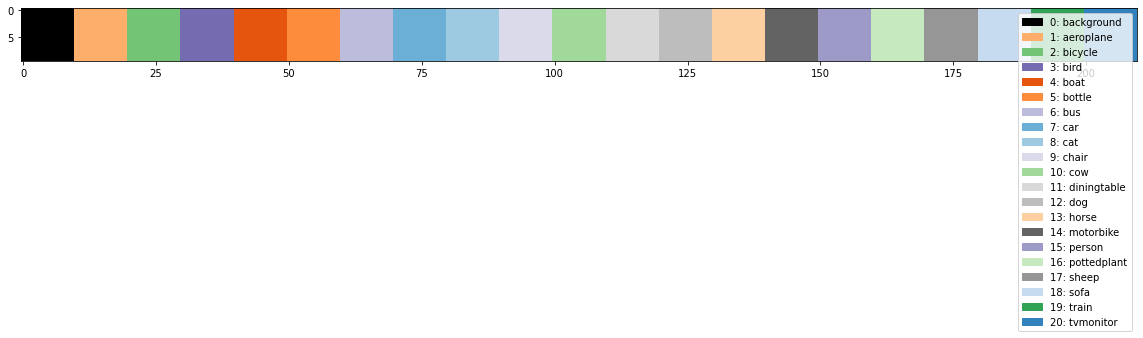

In [10]:
labels = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

cmap = plt.cm.get_cmap('tab20c')
colors = (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0]) # background color must be black
colors = np.array(colors, dtype=np.uint8)

palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., label='%d: %s' % (i, labels[i])))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(20, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)

# Segment Function

In [35]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    output = model(input_batch)['out'][0] # (21, height, width)

    output_predictions = output.argmax(0).byte().cpu().numpy() # (height, width) 

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

# Result

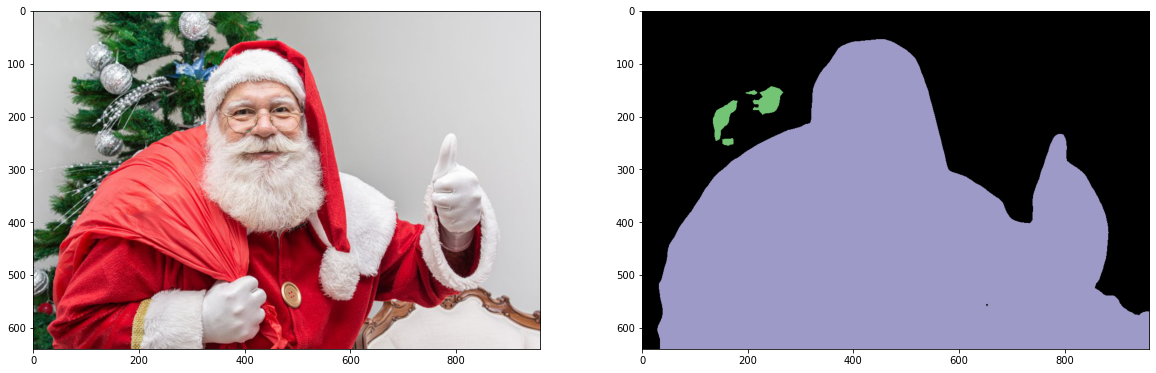

In [60]:
#img = np.array(Image.open(input_img))
img = np.array(Image.open("imgs/santa.jpg"))

fg_h, fg_w, _ = img.shape

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)

# Load Background Image and Resize
- make same size as foreground

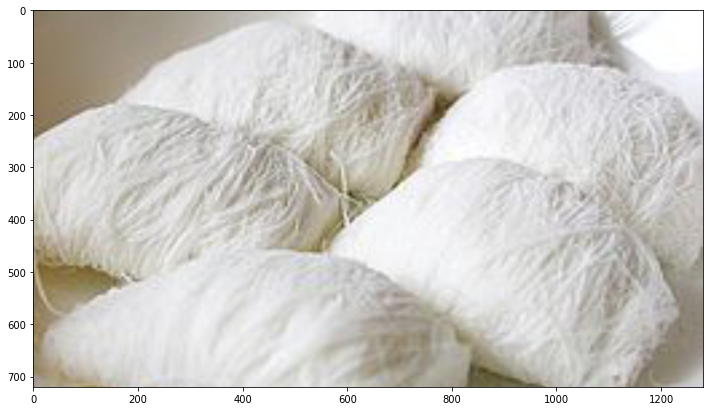

In [46]:
#background = np.array(Image.open(input_background))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)

# Separate Foreground and Background

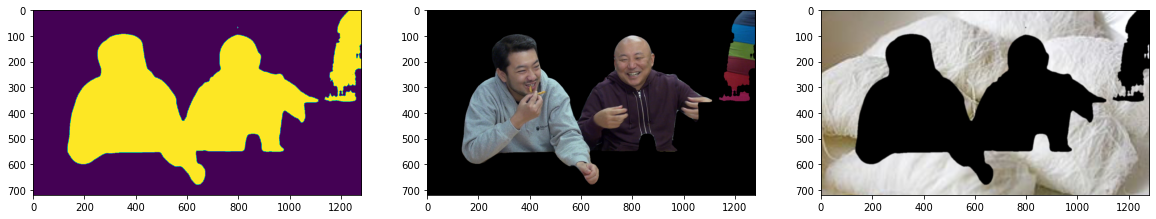

In [47]:
mask = (pred == 15).astype(float) * 255 # 15: person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
gray =  cv2.cvtColor(foreground.astype(np.uint8), cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
foreground = cv2.drawContours(foreground, contours, -1, (0,0,0), 5)

background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

# Result

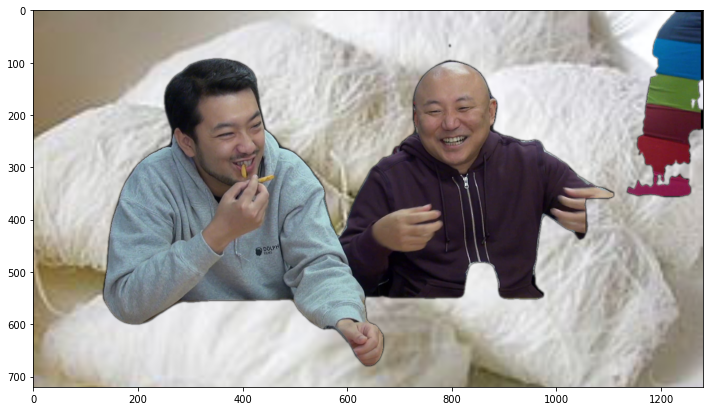

In [48]:
result = cv2.add(foreground, background).astype(np.uint8)

Image.fromarray(result).save('imgs/result.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(result)

# Blur Background

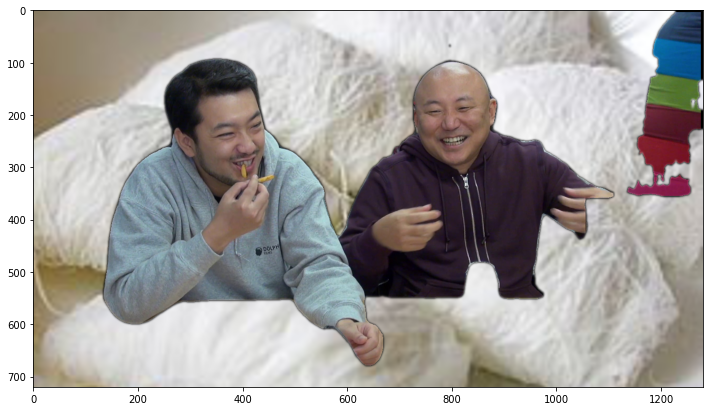

In [49]:
blurred_background = cv2.GaussianBlur(background, (5, 5), 0).astype(float)

bluured_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(bluured_result).save('imgs/result_blurred.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(bluured_result)

## Text Insertion


In [57]:
keyword = "2년동안 크리스마스에 군인일\n        예정인 건에 대하여"

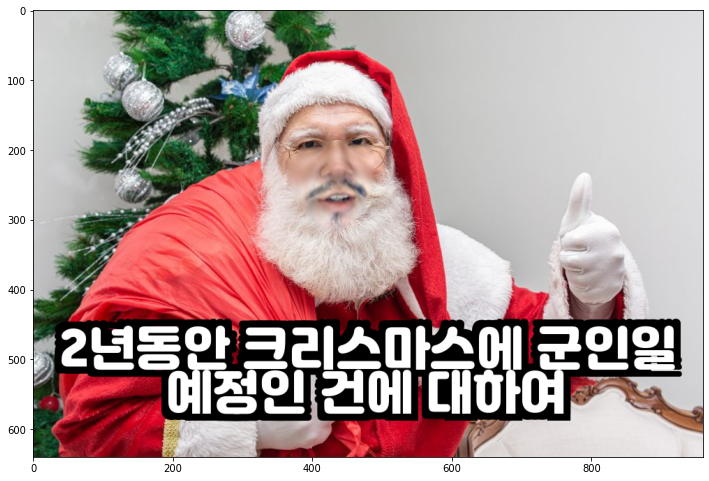

In [59]:
import random
#target_image = Image.open('imgs/result_blurred.jpg')
img = np.array(Image.open("imgs/test_santa.jpg"))
target_image = Image.open('imgs/test_santa.jpg')

img_shape = img.shape
fontsFolder = ''
if "\n" in keyword:
  font_size = int(2300/len(keyword))
else:
  font_size = int(1200/len(keyword))

font_list = ['TMONBlack.ttf', 'BinggraeⅡ-Bold.ttf', 'Jalnan.ttf']
font = font_list[random.randint(-1, len(font_list)-1)]
selectedFont =ImageFont.truetype(os.path.join(fontsFolder,font), font_size, encoding='UTF-8')
shadow = ImageFont.truetype(os.path.join(fontsFolder,font), font_size, encoding='UTF-8')
draw = ImageDraw.Draw(target_image)

color_shadow = (0,0,0)
color_font = (255,255,255)
shadow_w = 10
font_w, font_h = draw.textsize(keyword, selectedFont)
font_x = (img.shape[1] - font_w)/2
font_y = (img.shape[0] - font_h)*7/8

draw.text((font_x+10, font_y), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x-10, font_y), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x, font_y+10), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x, font_y-10), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x+10, font_y+10), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x-10, font_y+10), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x+10, font_y-10), keyword, fill=color_shadow,font=shadow,align='left')
draw.text((font_x-10, font_y-10), keyword, fill=color_shadow,font=shadow,align='left')

draw.text((font_x, font_y), keyword, fill=color_font,font=selectedFont,align='left')

plt.figure(figsize=(12,12))
plt.imshow(target_image)
target_image.save("result_final.jpg")

# Grayscale Background

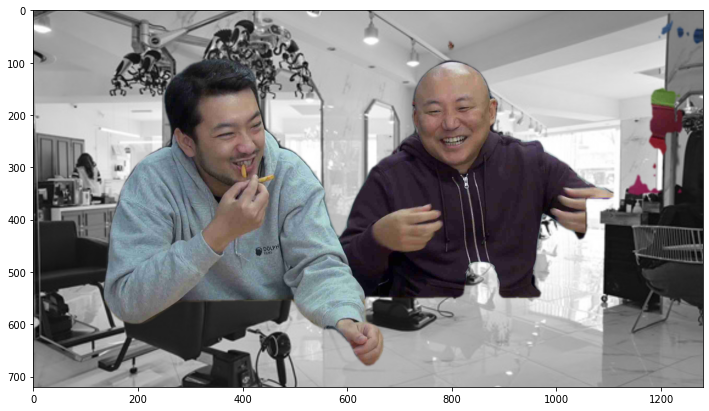

In [62]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float)

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

Image.fromarray(gray_result).save('imgs/result_gray.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(gray_result)